#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.2.2+cu121
Cude is available: True
Device name: NVIDIA A100-SXM4-40GB


#### **Import Other Libraries**

In [2]:
from datasets import load_dataset 
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
import numpy as np
import evaluate
from transformers import TrainingArguments
import torch 
import matplotlib.pyplot as plt 
from transformers import DataCollatorWithPadding
import os 
from pathlib import Path
import random 
from datasets import Dataset, DatasetDict
import warnings
from functools import partial
from datasets import concatenate_datasets
from functools import partial 
from tqdm import tqdm 
import textwrap
from IPython.display import display
from IPython.display import Markdown
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig
import os 
import re 
os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings('ignore', message='Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.')

#### **Parameters**

In [3]:
# This cell is tagged with `parameters`
model_name = "google/gemma-1.1-7b-it" #microsoft/phi-2" #"microsoft/phi-2" #"#"meta-llama/Llama-2-7b-chat-hf" # "distilbert-base-uncased" 
column = 'text'
epochs = 1
seed = 0
verbose = True 
test_size = 0.5
p = 0.0

#### **Set Up Path**

In [4]:
results_folder = str(Path(os.getcwd()).parent.parent.absolute())  + '/results/'
figures_folder = str(Path(os.getcwd()).parent.parent.absolute())  + '/figures/'
print(results_folder)

/home/ubuntu/llmft/results/


In [5]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### **Visual Checks**

In [6]:
### ---         Print Markdown
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))
### ---

### ---         Memory Check
def Memory():
    print("Current memory usage:")
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
### ---

Memory()

Current memory usage:
Allocated: 0.0 GB
Cached:    0.0 GB


#### **Qlora**

In [7]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig

# ----- QUANTIZATION -------# 
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# ----- LORA -------# 

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

Your GPU supports bfloat16: accelerate training with bf16=True


#### **Instantiate Model**

In [8]:
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             device_map="auto", 
                                             quantization_config=bnb_config, 
                                             trust_remote_code=True)# So we can do gradient checkpointing
print(model.generation_config)
Memory()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

GenerationConfig {
  "bos_token_id": 2,
  "eos_token_id": 1,
  "pad_token_id": 0
}

Current memory usage:
Allocated: 5.2 GB
Cached:    5.2 GB


#### **Peft Model**

In [9]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model.config.gradient_checkpointing = False


model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())
Memory()

trainable params: 25,001,984 || all params: 8,562,682,880 || trainable%: 0.29198773737606876
None
Current memory usage:
Allocated: 5.3 GB
Cached:    5.3 GB


#### **Tokenizer**

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'right'
# tokenizer.pad_token_id = tokenizer.eos_token_id 
# tokenizer.padding_side="left"
# model.config.pad_token_id = tokenizer.eos_token_id # ****I DON'T KNOW WHY WE NEED THIS??***

#### **Prompts**

In [11]:
def formatting_func(example):
    text = f"Quote: {example[column][0]}\Answer: {example['raw_label'][0]}"
    return [text]


#### **Assessment**

In [12]:
def find_first_true_or_false(text):
    # This regular expression pattern looks for 'Yes' or 'No' (case insensitive)
    pattern = r'\b(True|False)\b'
    
    # Search the text for the pattern
    match = re.search(pattern, text, re.IGNORECASE)
    
    # If a match is found, return the matched text, otherwise return None
    return match.group(0) if match else None

#### **Data set**

In [13]:
dataset = load_dataset(f"ppower1/covariates", split='train', download_mode="force_redownload")


# Reshuffle and split the combined dataset with a fixed seed
new_splits = dataset.train_test_split(test_size=test_size, seed=seed)  # adjust test_size as needed

# Create a new DatasetDict with the shuffled splits
reshuffled_dataset = DatasetDict({
    'train': new_splits['train'],
    'test': new_splits['test']
})


Generating train split:   0%|          | 0/9797 [00:00<?, ? examples/s]

In [14]:
# Memory measurement
Memory()
model_inputs = tokenizer(reshuffled_dataset['train'][column], return_tensors="pt", padding=True).to('cuda')
Memory()

Current memory usage:
Allocated: 5.3 GB
Cached:    5.3 GB
Current memory usage:
Allocated: 5.4 GB
Cached:    5.4 GB


In [24]:
trainer = SFTTrainer(
    model=model,
    train_dataset=reshuffled_dataset['train'],
    eval_dataset=reshuffled_dataset['test'],
    args=TrainingArguments(
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        load_best_model_at_end=True,

        gradient_accumulation_steps=4,
        warmup_steps=10,
        max_steps=100,
        evaluation_strategy = "steps",
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    peft_config=lora_config,
    formatting_func=formatting_func,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/home/ubuntu/llms/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/4899 [00:00<?, ? examples/s]

/home/ubuntu/llms/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/home/ubuntu/llms/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [26]:
reshuffled_dataset['test'].shape

(4899, 3)

In [25]:
trainer.train()


Step,Training Loss,Validation Loss


TrainOutput(global_step=100, training_loss=0.0023713491344824434, metrics={'train_runtime': 148.7673, 'train_samples_per_second': 10.755, 'train_steps_per_second': 0.672, 'total_flos': 1.264889633891328e+16, 'train_loss': 0.0023713491344824434, 'epoch': 100.0})

In [27]:
steps, train_loss =   [i['step'] for i in trainer.state.log_history if 'loss' in i],  [i['loss'] for i in trainer.state.log_history if 'loss' in i]
eval_loss = [i['eval_loss'] for i in trainer.state.log_history if 'eval_loss' in i]

In [28]:
trainer.state.log_history 

[{'loss': 0.0019,
  'grad_norm': 0.029383506625890732,
  'learning_rate': 2e-05,
  'epoch': 1.0,
  'step': 1},
 {'eval_loss': 3.604884386062622,
  'eval_runtime': 0.3545,
  'eval_samples_per_second': 14.106,
  'eval_steps_per_second': 5.642,
  'epoch': 1.0,
  'step': 1},
 {'loss': 0.0021,
  'grad_norm': 0.03982532396912575,
  'learning_rate': 4e-05,
  'epoch': 2.0,
  'step': 2},
 {'eval_loss': 3.612865447998047,
  'eval_runtime': 0.3321,
  'eval_samples_per_second': 15.054,
  'eval_steps_per_second': 6.021,
  'epoch': 2.0,
  'step': 2},
 {'loss': 0.0018,
  'grad_norm': 0.02300567366182804,
  'learning_rate': 6e-05,
  'epoch': 3.0,
  'step': 3},
 {'eval_loss': 3.64190411567688,
  'eval_runtime': 0.3299,
  'eval_samples_per_second': 15.155,
  'eval_steps_per_second': 6.062,
  'epoch': 3.0,
  'step': 3},
 {'loss': 0.0023,
  'grad_norm': 0.04858225956559181,
  'learning_rate': 8e-05,
  'epoch': 4.0,
  'step': 4},
 {'eval_loss': 3.682926893234253,
  'eval_runtime': 0.33,
  'eval_samples_per

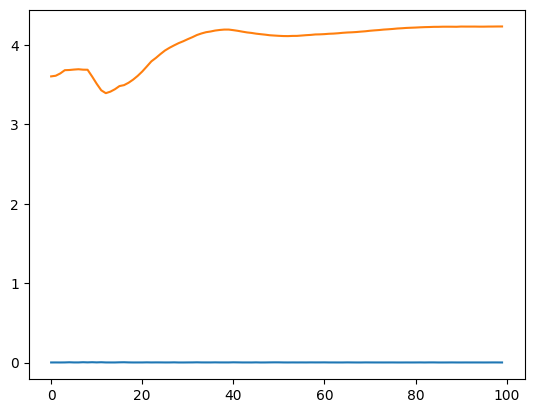

In [29]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.show()